In [1]:
!pip install pyreclab --upgrade

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.2/267.2 KB 1.8 MB/s eta 0:00:00a 0:00:01


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyreclab
import scipy.sparse as sparse

## Lectura de datos

A diferencia de los otros métodos utilizados en la sección de ranking, necesitamos leer los datos únicamente para el cálculo de métricas como Recall@k, Novedad y Diversidad.

In [2]:
df_train = pd.read_csv(os.path.join('..', 'data', 'training_set.csv'),
                         sep=',',
                         names=['userid', 'itemid', 'styleid', 'rating'],
                         header=0)

# rating >= 3 , relevante (1) y rating menor a 3 es no relevante (0)
df_train.rating = [1 if x >=3 else 0 for x in df_train.rating ]

In [3]:
# Cargamos el dataset de testing
df_validation = pd.read_csv(os.path.join('..', 'data', 'validation_set.csv'),
                      sep=',',
                      names=['userid', 'itemid', 'styleid', 'rating'],
                      header=0)


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
df_validation.rating = [1 if x >=3 else 0 for x in df_validation.rating ]


user_items_test = {}

for row in df_validation.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [4]:
df_item_styles = pd.read_csv(os.path.join('..', 'data', 'items_styles.csv'),
                            sep=',',
                            names=['itemid', 'styleid'],
                            header=0)
df_item_styles.head()

,itemid,styleid
0,11757,1199
1,5441,1199
2,19960,1199
3,55900,1199
4,57110,14879


## Definición de métricas

In [5]:
def recall_at_k(r, k, m):
    return (np.asarray(r)[:k] != 0).sum() / m

In [6]:
item_counts = df_train["itemid"].value_counts()
total_interactions = len(df_train)
items_popularity = item_counts / total_interactions
items_popularity = items_popularity.to_dict()

def novelty_for_user(recommendations):
    popularities = np.array([items_popularity[i] for i in recommendations])
    return np.sum(np.log(1 / popularities)) / len(recommendations)

In [7]:
item_categories = df_item_styles.set_index("itemid")["styleid"].to_dict()

def diversity_for_user(recommendations, categories=item_categories):
    recommended_categories = [categories[item] for item in recommendations]
    unique_categories = len(set(recommended_categories))

    return unique_categories / len(recommendations)

In [8]:
def evaluate_model(recommended_list, n):
  mean_recall = 0.
  novelty = 0
  diversity = 0

  for u in recommended_list.keys():
    relevant_items = user_items_test[int(u)]
    rec = [int(item) for item in recommended_list[u]]
    rel_vector = np.isin(relevant_items, rec, assume_unique=True).astype(int)    
    
    mean_recall += recall_at_k(rel_vector, n, len(relevant_items))
    novelty += novelty_for_user(rec)
    diversity += diversity_for_user(rec)

  mean_recall /= len(user_items_test)
  novelty /= len(user_items_test)
  diversity /= len(user_items_test)
  
  return mean_recall, novelty, diversity

In [9]:
svd = pyreclab.SVD(dataset=os.path.join('..', 'data', 'training_set.csv'),
                   dlmchar=b',',
                   header=True,
                   usercol=0,
                   itemcol=1,
                   ratingcol=3)

svd.train(factors=100, maxiter=100, lr=0.01, lamb=0.1)

In [10]:
recommendedList, map, ndcg = svd.testrec(input_file=os.path.join('..', 'data', 'validation_set.csv'),
                                 dlmchar=b',',
                                 header=True,
                                 usercol=0,
                                 itemcol=1,
                                 ratingcol=3)

recall, novelty, diversity = evaluate_model(recommendedList, 10)

print(f"MAP@10: {map}")
print(f"nDCG@10: {ndcg}")
print(f"Recall@10: {recall}")
print(f"Novelty: {novelty}")
print(f"Diversity: {diversity}")

MAP@10: 0.008048922518306464
nDCG@10: 0.005970149364017641
Recall@10: 0.010180406917943571
Novelty: 9.51536408730521
Diversity: 0.7507331378299114


## Análisis de sensibilidad

In [40]:
factor_values = [20, 30, 50, 70, 100]  
map_values = []
ndcg_values = []

for factor in factor_values:
    svd.train(factors=factor, maxiter=100, lr=0.01, lamb=0.1)
    recommendedList, map, ndcg = svd.testrec(input_file=os.path.join('..', 'data', 'validation_set.csv'),
                                             dlmchar=b',',
                                             header=True,
                                             usercol=0,
                                             itemcol=1,
                                             ratingcol=3)
    map_values.append(map)
    ndcg_values.append(ndcg)

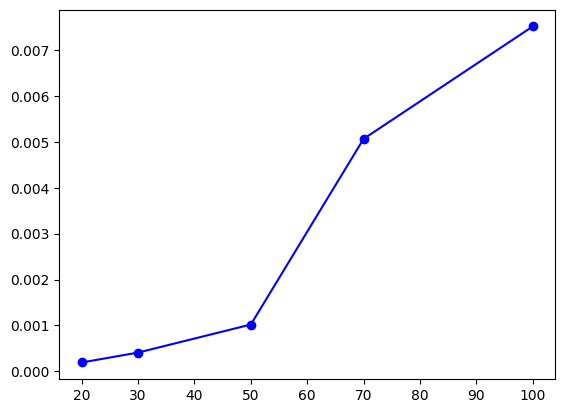

In [42]:
plt.plot(factor_values, map_values, "bo-")
plt.show()

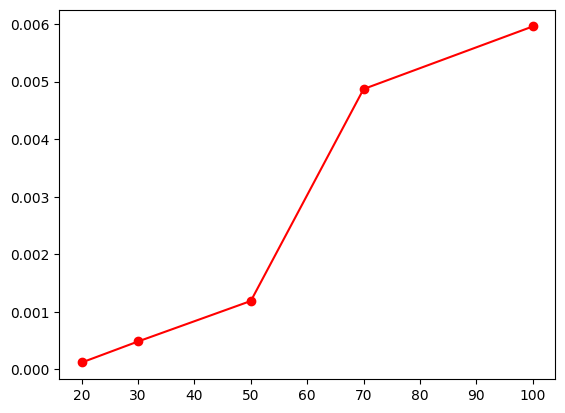

In [43]:
plt.plot(factor_values, ndcg_values, "ro-")
plt.show()

In [20]:
lr_values = [0.001, 0.005, 0.01, 0.05, 0.1]
map_values = []
ndcg_values = []

for lr in lr_values:
    svd.train(factors=100, maxiter=100, lr=lr, lamb=0.1)
    recommendedList, map, ndcg = svd.testrec(input_file=os.path.join('..', 'data', 'validation_set.csv'),
                                             dlmchar=b',',
                                             header=True,
                                             usercol=0,
                                             itemcol=1,
                                             ratingcol=3)
    map_values.append(map)
    ndcg_values.append(ndcg)

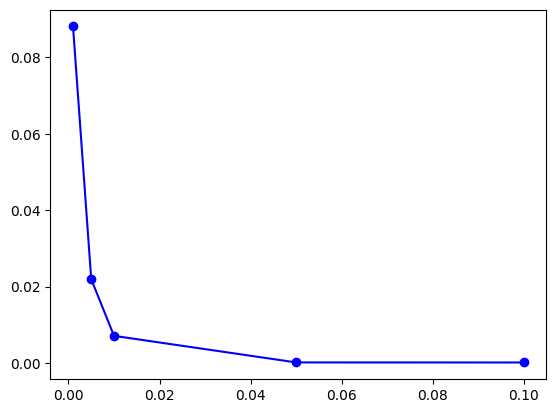

In [22]:
plt.plot(lr_values, map_values, "bo-")
plt.show()

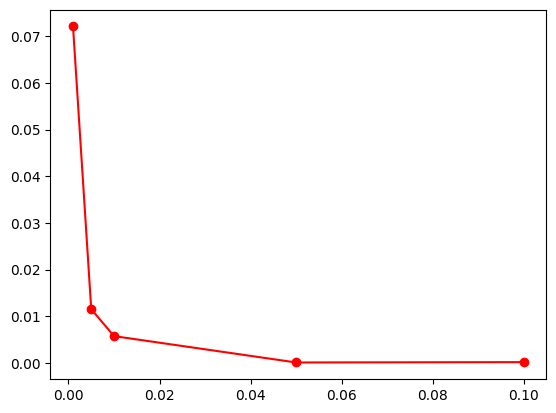

In [24]:
plt.plot(lr_values, ndcg_values, "ro-")
plt.show()

In [25]:
lambda_values = [0.001, 0.005, 0.01, 0.05, 0.1]
map_values = []
ndcg_values = []

for lamb in lambda_values:
    svd.train(factors=100, maxiter=100, lr=0.1, lamb=lamb)
    recommendedList, map, ndcg = svd.testrec(input_file=os.path.join('..', 'data', 'validation_set.csv'),
                                             dlmchar=b',',
                                             header=True,
                                             usercol=0,
                                             itemcol=1,
                                             ratingcol=3)
    map_values.append(map)
    ndcg_values.append(ndcg)

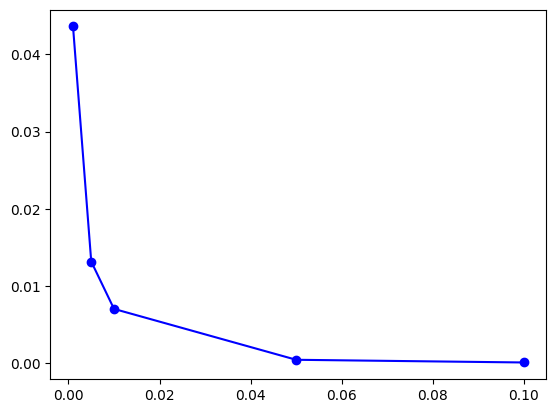

In [26]:
plt.plot(lr_values, map_values, "bo-")
plt.show()

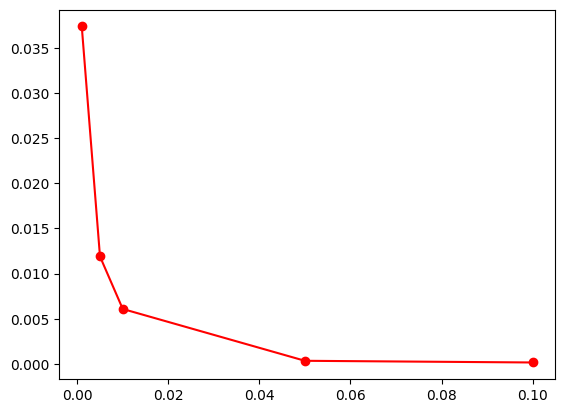

In [27]:
plt.plot(lr_values, ndcg_values, "ro-")
plt.show()

In [18]:
factor_values = [20, 30, 40, 60, 80, 100]   
lr_values = [0.001, 0.005, 0.01, 0.05, 0.1]

map_values = []
ndcg_values = []

for factors in factor_values:
    map_row = []
    ndcg_row = []
    for lr in lr_values:
        svd.train(factors=factors, maxiter=100, lr=lr, lamb=0.1)
        recommendedList, map_value, ndcg = svd.testrec(input_file=os.path.join('..', 'data', 'validation_set.csv'),
                                             dlmchar=b',',
                                             header=True,
                                             usercol=0,
                                             itemcol=1,
                                             ratingcol=3)

        map_row.append(map_value)
        ndcg_row.append(ndcg)
    map_values.append(map_row)
    ndcg_values.append(ndcg_row)

factors_values, lr_values = np.meshgrid(factor_values, lr_values)


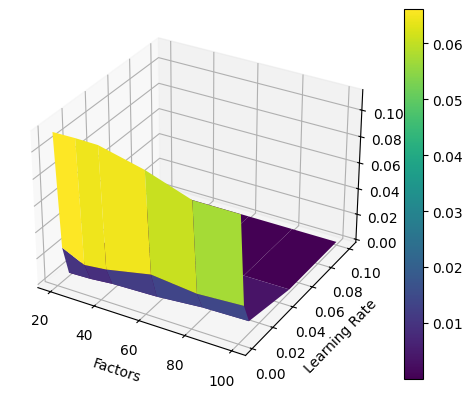

In [19]:
from matplotlib import cm
map_values = np.array(map_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(factors_values, lr_values, map_values.T, cmap=cm.viridis)

ax.set_xlabel('Factors')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('MAP@10')

fig.colorbar(surf)
plt.show()

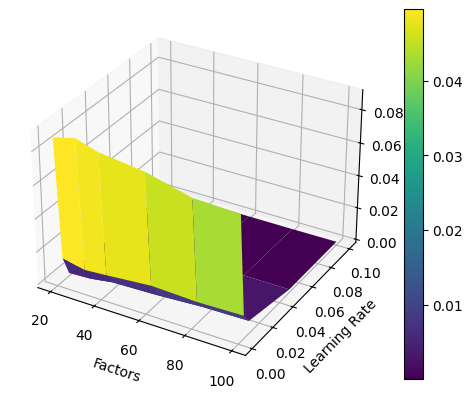

In [20]:
ndcg_values = np.array(ndcg_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(factors_values, lr_values, ndcg_values.T, cmap=cm.viridis)

ax.set_xlabel('Factors')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('nDCG@10')

fig.colorbar(surf)
plt.show()

In [28]:
factor_values = [20, 30, 40, 60, 80, 100]   
lambda_values = [0.001, 0.005, 0.01, 0.05, 0.1]

map_values = []
ndcg_values = []

for factors in factor_values:
    map_row = []
    ndcg_row = []
    for lamb in lambda_values:
        svd.train(factors=factors, maxiter=100, lr=0.1, lamb=lamb)
        recommendedList, map_value, ndcg = svd.testrec(input_file=os.path.join('..', 'data', 'validation_set.csv'),
                                             dlmchar=b',',
                                             header=True,
                                             usercol=0,
                                             itemcol=1,
                                             ratingcol=3)

        map_row.append(map_value)
        ndcg_row.append(ndcg)
    map_values.append(map_row)
    ndcg_values.append(ndcg_row)

factors_values, lambda_values = np.meshgrid(factor_values, lambda_values)


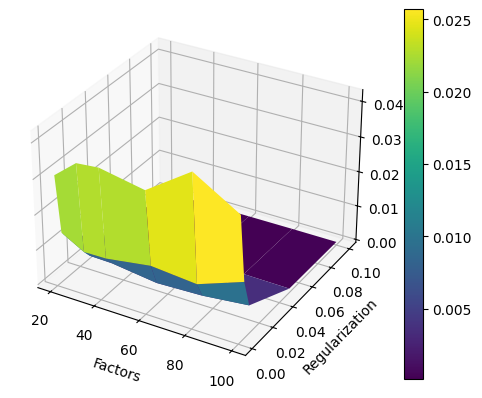

In [30]:
from matplotlib import cm
map_values = np.array(map_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(factors_values, lambda_values, map_values.T, cmap=cm.viridis)

ax.set_xlabel('Factors')
ax.set_ylabel('Regularization')
ax.set_zlabel('MAP@10')

fig.colorbar(surf)
plt.show()

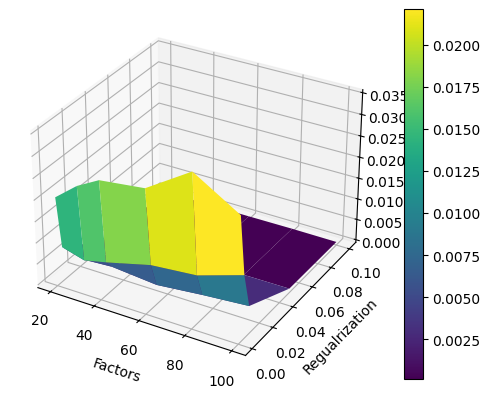

In [31]:
ndcg_values = np.array(ndcg_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(factors_values, lambda_values, ndcg_values.T, cmap=cm.viridis)

ax.set_xlabel('Factors')
ax.set_ylabel('Regualrization')
ax.set_zlabel('nDCG@10')

fig.colorbar(surf)
plt.show()

In [32]:
lr_values = [0.001, 0.005, 0.01, 0.05, 0.1]
lambda_values = [0.001, 0.005, 0.01, 0.05, 0.1]

map_values = []
ndcg_values = []

for lr in lr_values:
    map_row = []
    ndcg_row = []
    for lamb in lambda_values:
        svd.train(factors=100, maxiter=100, lr=lr, lamb=lamb)
        recommendedList, map_value, ndcg = svd.testrec(input_file=os.path.join('..', 'data', 'validation_set.csv'),
                                             dlmchar=b',',
                                             header=True,
                                             usercol=0,
                                             itemcol=1,
                                             ratingcol=3)

        map_row.append(map_value)
        ndcg_row.append(ndcg)
    map_values.append(map_row)
    ndcg_values.append(ndcg_row)

lr_values, lambda_values = np.meshgrid(lr_values, lambda_values)


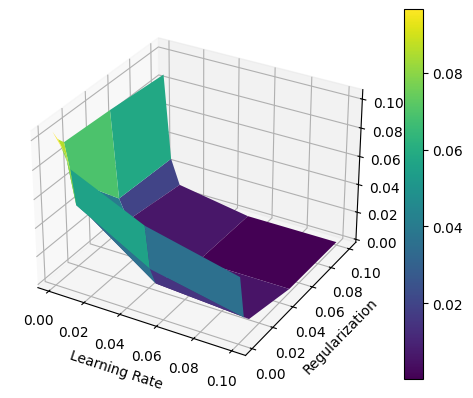

In [33]:
map_values = np.array(map_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(lr_values, lambda_values, map_values.T, cmap=cm.viridis)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Regularization')
ax.set_zlabel('MAP@10')

fig.colorbar(surf)
plt.show()

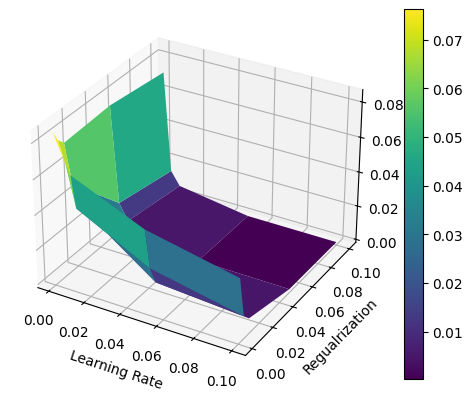

In [34]:
ndcg_values = np.array(ndcg_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(lr_values, lambda_values, ndcg_values.T, cmap=cm.viridis)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Regualrization')
ax.set_zlabel('nDCG@10')

fig.colorbar(surf)
plt.show()

## Métricas de desempeño

## Ranking con datos de testeo

In [10]:
import json

test = json.load(open(os.path.join("..", "templates", "ranking_template_fill.json")))

{'3022': [''], '4049': [''], '1122': [''], '1156': [''], '3386': [''], '1818': [''], '3510': [''], '5224': [''], '6323': [''], '8176': [''], '1260': [''], '2725': [''], '4971': [''], '2049': [''], '1406': [''], '3201': [''], '3105': [''], '1637': [''], '734': [''], '7388': [''], '1401': [''], '7472': [''], '7084': [''], '7792': [''], '7525': [''], '6890': [''], '2466': [''], '3942': [''], '3536': [''], '530': [''], '8047': [''], '6891': [''], '6069': [''], '6020': [''], '6459': [''], '1865': [''], '557': [''], '5192': [''], '2736': [''], '4910': [''], '2389': [''], '6511': [''], '7461': [''], '1690': [''], '5445': [''], '6734': [''], '1817': [''], '4448': [''], '3790': [''], '7966': [''], '2329': [''], '6084': [''], '3339': [''], '641': [''], '6275': [''], '6065': [''], '4281': [''], '7222': [''], '1504': [''], '713': [''], '2733': [''], '7890': [''], '5976': [''], '3126': [''], '6660': [''], '1770': [''], '7494': [''], '3316': [''], '1486': [''], '2624': [''], '1795': [''], '5483': ['

In [16]:
for user in test.keys():
    ranking = svd.recommend(user)
    ranking = [int(r) for r in ranking]
    test[user] = ranking


In [17]:
with open(os.path.join("..", "predictions", "FunkSVD_ranking.json"), "w") as file:
    json.dump(test, file, indent=4)